In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import numpy as np 
import pandas as pd 
import collections
import torch
import json
import os
import cv2
import random
import gc
import pycocotools

from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Dataset

In [7]:
# Get training dataframe
data_dir = Path('data/raw')
image_dir = Path('data/raw/train/')
df = pd.read_csv(data_dir/'train.csv')

# Load modified df for Detectron2 dataset dict 
df_detectron = pd.read_csv('data/interim/df_detectron2.csv') 

# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])

In [8]:
# Rle helper functions

def rle_decode_string(rle, h, w):
    '''
    rle: run-length encoded image mask, as string
    h: heigh of image on which RLE was produced
    w: width of image on which RLE was produced
    returns a binary mask with the same shape
    '''
    mask = np.full(h*w, 0, dtype=np.uint8)
    annotation = [int(x) for x in rle.split(' ')]
    for i, start_pixel in enumerate(annotation[::2]):
        mask[start_pixel: start_pixel+annotation[2*i+1]] = 1
    mask = mask.reshape((h, w), order='F')

    return mask

def rle2bbox(rle, shape):
    '''
    Get a bbox from a mask which is required for Detectron 2 dataset
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1

### Dataset dict function

In [9]:
# https://detectron2.readthedocs.io/tutorials/datasets.html
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

def get_fashion_dict(df):
    
    dataset_dicts = []
    
    for idx, filename in enumerate(df['ImageId'].unique().tolist()):
        
        record = {}
        
        record['height'] = int(df[df['ImageId']==filename]['Height'].values[0])
        record['width'] = int(df[df['ImageId']==filename]['Width'].values[0])
        record['file_name'] = filename
        record['image_id'] = idx
        
        objs = []
        for index, row in df[(df['ImageId']==filename)].iterrows():
            
            # Get binary mask
            mask = rle_decode_string(row['EncodedPixels'], row['Height'], row['Width'])
            
            # Transform the mask from binary to polygon format
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                    cv2.CHAIN_APPROX_SIMPLE)                                            
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)    
            
            # Data for each mask
            obj = {
                'bbox': [row['x0'], row['y0'], row['x1'], row['y1']],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': row['ClassId'],
                'segmentation': segmentation,
                'iscrowd': 0
            }
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
# To view a sample of fashion_dict
fashion_dict = get_fashion_dict(df_detectron[:100])

In [11]:
# Arbitrary split in training / testing dataframes
df_copy_test = df_detectron[-66680:].copy()

## Register datasets

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the train and test and set metadata
for d in ['test']:
    DatasetCatalog.register('sample_fashion_' + d, lambda d=df_copy_test: get_fashion_dict(d))
    MetadataCatalog.get("sample_fashion_" + d).set(thing_classes=list(df_categories.name))
fashion_metadata = MetadataCatalog.get("sample_fashion_test")

## Inference & evaluation using the trained model

### Load et setup configs

In [13]:
cfg = get_cfg()

# Get Coco Instance Segmentation configs
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Create new output_dir based on experience number
cfg.OUTPUT_DIR = "./output/exp02"

# Get our trained model's weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('sample_fashion_test',) # must be a tuple

# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 600
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 900

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 50000    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 47  # 46 classes in iMaterialist

#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # default: 512
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 47  # 46 classes in iMaterialist



predictor = DefaultPredictor(cfg)

In [14]:
# Create output folder to dump all ouputs (tensorboard logs, model weigts, etc.)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## View Inference on Sample Images

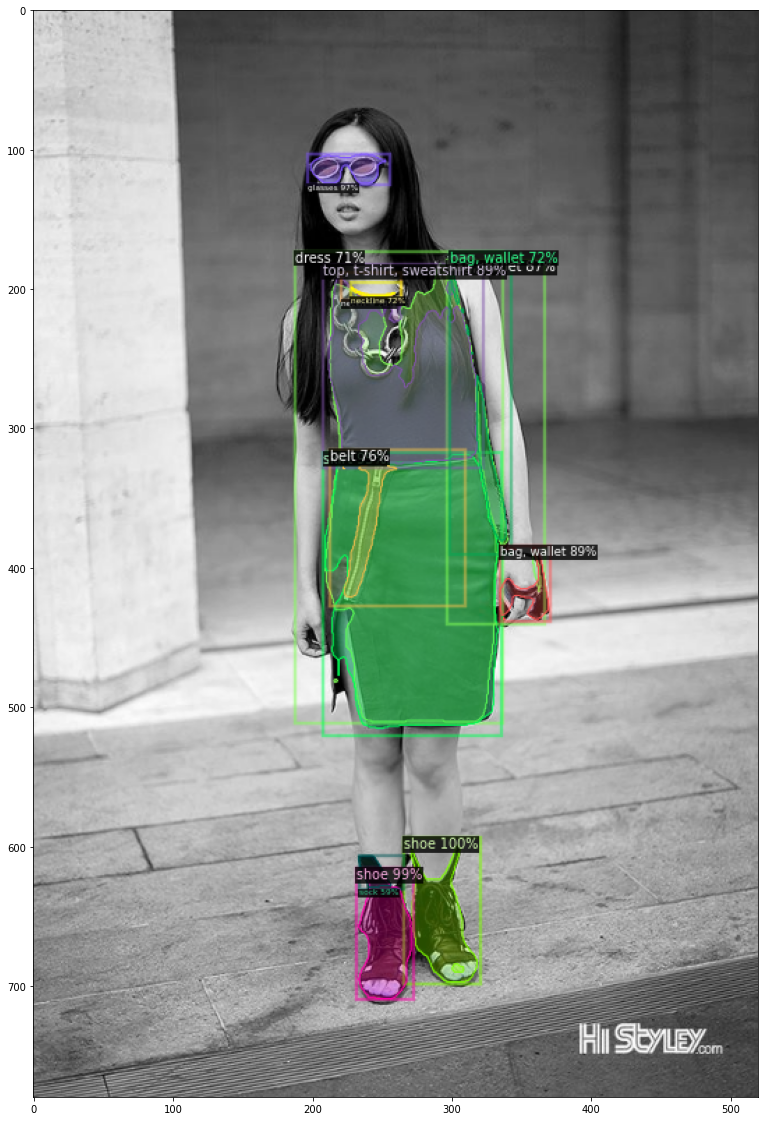

In [15]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(fashion_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

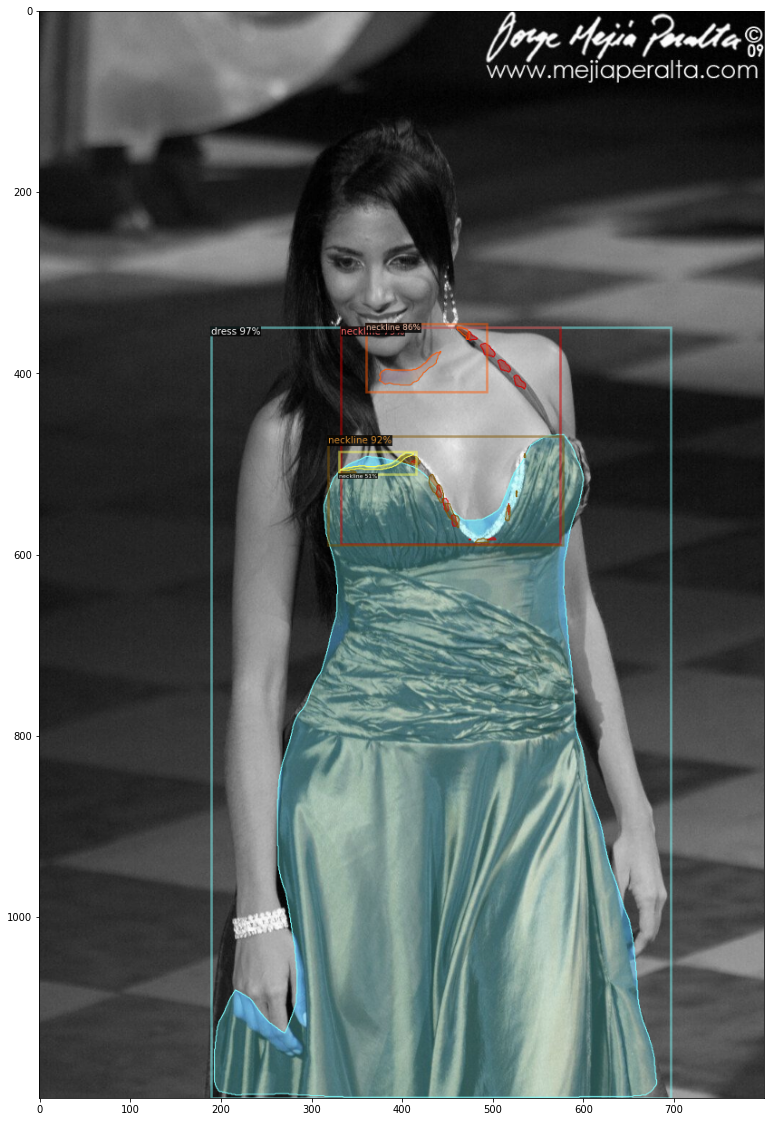

In [16]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(fashion_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

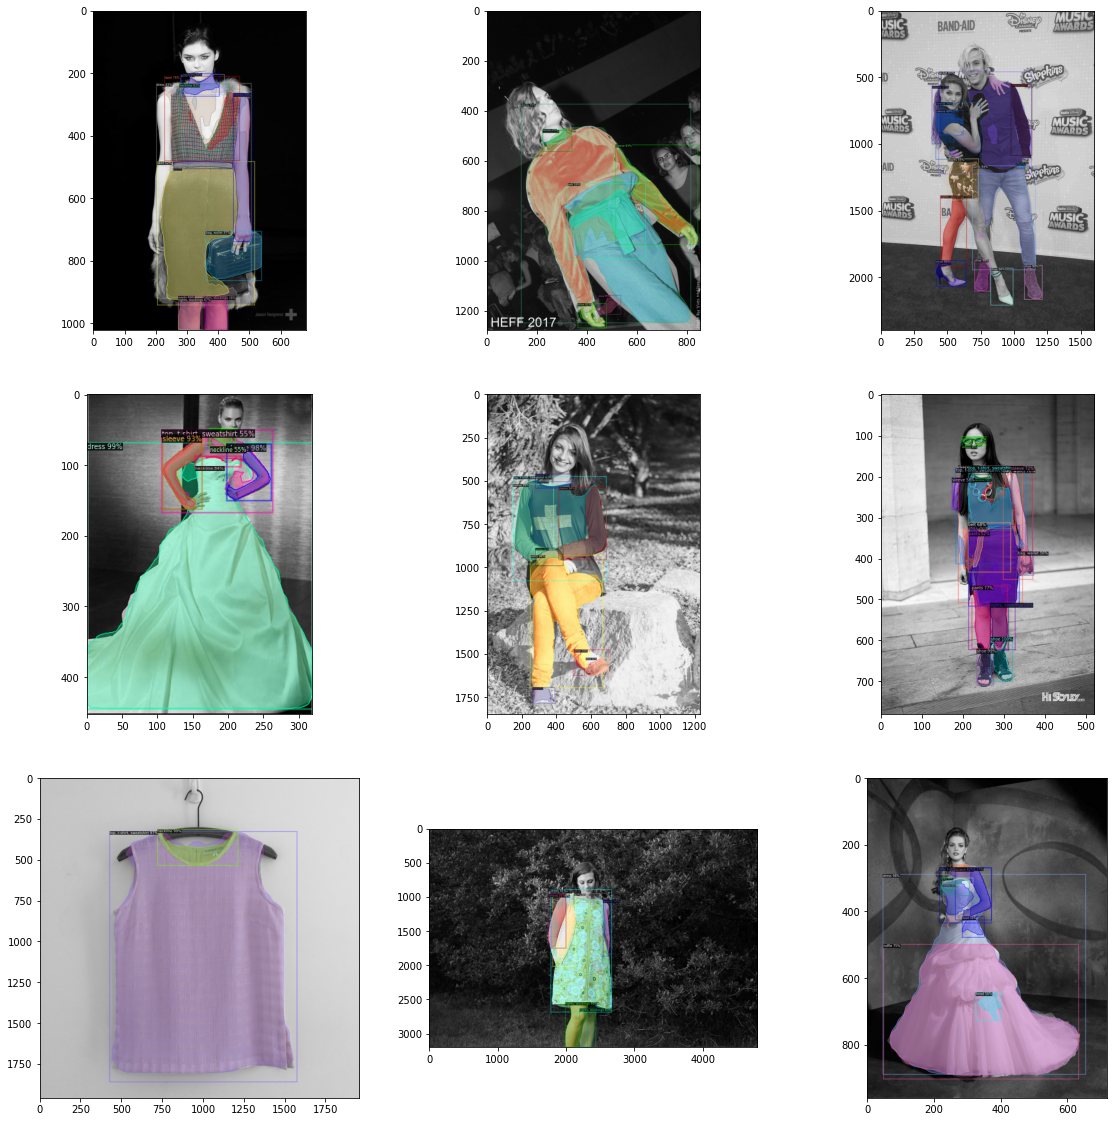

In [17]:
# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, d in enumerate(random.sample(fashion_dict, 9)):
    
    # Process image
    plt.subplot(rows, cols, i+1)

    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()

## Evaluate performance using AP metric implemented in COCO API

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("sample_fashion_test", cfg, False, output_dir="./output/exp03")

In [ ]:
val_loader = build_detection_test_loader(cfg, "sample_fashion_test")

In [ ]:
inference_on_dataset(trainer.model, val_loader, evaluator)
